In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import torch
import os
import pickle
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/iam_dataset/saved_model/resnet/'
data_path = '/content/drive/MyDrive/iam_dataset/'

In [ ]:
# toggles
pre_trained = True
train_on_node1 = False
pre_trained_on_node1_use_on_node2 = False


save_results = False
save_model = False

In [ ]:
labelled_data = np.load(data_path + 'labelled_data.npy')

print(labelled_data.shape)

(4901, 2)


In [ ]:
labelled_data_0 = labelled_data[labelled_data[:,1] == '000']

print(labelled_data_0.shape)

if pre_trained_on_node1_use_on_node2:
  labelled_data_0 = labelled_data_0[196:(196*2)]
else:
  labelled_data_0 = labelled_data_0[:196]
print(labelled_data_0.shape)

print(np.unique(labelled_data_0[:,1]))

(693, 2)
(196, 2)
['000']


In [ ]:
remove_0 = labelled_data[labelled_data[:,1]!='000']

print(np.unique(remove_0[:,1]))
print(np.unique(remove_0[:,1]).shape)

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(49,)


In [ ]:
y = [remove_0[remove_0[:,1]==k] for k in np.unique(remove_0[:,1])]
print(len(y))

49


In [ ]:
labelled_data_1 = []
for i in y:
  if pre_trained_on_node1_use_on_node2:
    labelled_data_1.append(i[5:9])
  else:
    labelled_data_1.append(i[:4])


print(len(labelled_data_1))

labelled_data_1 = np.array(labelled_data_1)

print(labelled_data_1.shape)

49
(49, 4, 2)


In [ ]:
labelled_data_1=labelled_data_1.reshape(-1,2)

In [ ]:
print(np.unique(labelled_data_1[:,1]))

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']


In [ ]:
labelled_data_new = np.concatenate((labelled_data_0, labelled_data_1))
np.random.shuffle(labelled_data_new)
print(labelled_data_new.shape) # mix of sentences from writer id 0 and others, labelled

(392, 2)


In [ ]:
# split before augmenting to ensure the sentences are being split and not the augmented samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labelled_data_new[:,0], labelled_data_new[:,1], test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(262,) (130,) (262,) (130,)


In [ ]:
from sklearn.utils import shuffle
from PIL import Image
import random

CROP_SIZE = 113
NUM_LABELS = 50

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return images, labels

In [ ]:
def augment(data, labels):
    augmented_sample_list = []
    augmented_label_list = []
    for i in range(len(data)):
        augmented_samples, augmented_labels = get_augmented_sample(data[i], labels[i],0.1)
        augmented_sample_list.append(augmented_samples)
        augmented_label_list.append(augmented_labels)
    return augmented_sample_list, augmented_label_list

In [ ]:
augsamps, auglbls = augment(X_train, y_train) # returns two lists of arrays
ausamps_test, auglbls_test = augment(X_test, y_test)

In [ ]:
import operator
from functools import reduce

# flattening the lists
aug_samps = reduce(operator.add, augsamps)
aug_lbls = reduce(operator.add, auglbls)

aug_samps_test = reduce(operator.add, ausamps_test)
aug_lbls_test = reduce(operator.add, auglbls_test)
print(len(aug_samps))
print(len(aug_lbls))

print(len(aug_samps_test))
print(len(aug_lbls_test))

40670
40670
19312
19312


In [ ]:
# converting lists to arrays
aug_samps_arr = np.array(aug_samps)
aug_lbls_arr = np.array(aug_lbls)
aug_samps_arr_test = np.array(aug_samps_test)
aug_lbls_arr_test = np.array(aug_lbls_test)

print(aug_samps_arr.shape)
print(aug_lbls_arr.shape)
print(aug_samps_arr_test.shape)
print(aug_lbls_arr_test.shape)

(40670, 113, 113)
(40670,)
(19312, 113, 113)
(19312,)


In [ ]:
X_train = aug_samps_arr
X_train = X_train.reshape(X_train.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_train = X_train.astype('float16')
X_train /= 255.0
y_train = aug_lbls_arr

In [ ]:
X_test = aug_samps_arr_test
X_test = X_test.reshape(X_test.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_test = X_test.astype('float16')
X_test /= 255.0
y_test = aug_lbls_arr_test

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(40670, 1, 113, 113)
(40670,)
(19312, 1, 113, 113)
(19312,)


In [ ]:
new = np.unique(y_train)
print(new)

y_train[y_train !='000'] = 1
new = np.unique(y_train)
print(new)

y_train[y_train=='000'] = 0 # 0 is 0
new = np.unique(y_train)
print(new)

print(y_train.shape)

y_train = y_train.astype('float16')

print(np.unique(y_train))

['000' '085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204'
 '205' '206' '207' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '567' '588' '634' '635' '670' '671']
['000' '1']
['0' '1']
(40670,)
[0. 1.]


In [ ]:
new = np.unique(y_test)
print(new)

y_test[y_test !='000'] = 1
new = np.unique(y_test)
print(new)

y_test[y_test=='000'] = 0
new = np.unique(y_test)
print(new)

print(y_test.shape)

y_test = y_test.astype('float16')

print(np.unique(y_test))

['000' '151' '152' '153' '154' '155' '202' '203' '204' '205' '206' '207'
 '208' '209' '247' '273' '315' '333' '334' '335' '336' '337' '338' '339'
 '340' '341' '342' '343' '344' '346' '347' '348' '349' '384' '551' '552'
 '567' '588' '634' '635' '670']
['000' '1']
['0' '1']
(19312,)
[0. 1.]


In [ ]:
torch.manual_seed(42)
CUDA = torch.cuda.is_available()
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch import nn


tensor_x_train = torch.Tensor(X_train).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).type(torch.cuda.FloatTensor).long()

# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=64, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
tensor_x_train.shape

torch.Size([40670, 1, 113, 113])

In [ ]:
tensor_x_test = torch.Tensor(X_test).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).long().type(torch.cuda.FloatTensor).long()

# tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
# tensor_y_test = torch.Tensor(y_test).long()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True) # create your dataloader

In [ ]:
import torch
import torchvision.models as models
if pre_trained:
  model = models.resnet18(pretrained=True)
else:
  model = models.resnet18(pretrained=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# change first conv to take 1 channel instead of 3
print(model.conv1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)
print(model.conv1)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2).to(device)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
if pre_trained or pre_trained_on_node1_use_on_node2:
  for param in model.parameters():
    param.requires_grad = False

In [ ]:
if pre_trained or pre_trained_on_node1_use_on_node2:
  for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2).to(device)

In [ ]:
if pre_trained_on_node1_use_on_node2:
  if os.path.exists(save_path + 'trained_on_node1.pt'):
      print('Loading checkpoint: %s' % save_path + 'trained_on_node1.pt')
      path = torch.load(save_path + 'trained_on_node1.pt')
      # epoch = path['epoch']
      model.load_state_dict(path['model'])
      optimizer.load_state_dict(path['optimizer'])

In [ ]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
train_losses = []
train_loss_record = []

In [ ]:
from datetime import datetime
train_log_string = '%s :: Epoch %i :: Iter %i / %i :: train loss: %0.4f'
def train(epoch):
    print('Start Epoch {} Training...'.format(epoch))
    model.train()
    train_loss = []
    train_loss_sum = []
    for idx, (data, target) in enumerate(train_dataloader):
        # data = data.to(device)
        # target = target.to(device)
        # print(data.shape)
        optimizer.zero_grad()
        #  forward-pass
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy())
        train_loss_sum.append(loss)
        if ((idx +1) % 5000) == 0:
          print(train_log_string % (datetime.now(), epoch, idx + 1, len(train_dataloader), np.mean(train_loss)))
          train_loss = []
    mean_tr = torch.mean(torch.stack(train_loss_sum))
    print('Train Loss at epoch {}: {}\n'.format(epoch, mean_tr))
    train_loss_record.append(mean_tr)
    return train_loss_record

In [ ]:
for epoch in range(10):
    tlr = train(epoch)

Start Epoch 0 Training...
Train Loss at epoch 0: 0.11432097107172012

Start Epoch 1 Training...
Train Loss at epoch 1: 0.049613043665885925

Start Epoch 2 Training...
Train Loss at epoch 2: 0.03277982398867607

Start Epoch 3 Training...
Train Loss at epoch 3: 0.026391463354229927

Start Epoch 4 Training...
Train Loss at epoch 4: 0.021854378283023834

Start Epoch 5 Training...
Train Loss at epoch 5: 0.020751670002937317

Start Epoch 6 Training...
Train Loss at epoch 6: 0.017278209328651428

Start Epoch 7 Training...
Train Loss at epoch 7: 0.016277072951197624

Start Epoch 8 Training...
Train Loss at epoch 8: 0.014405356720089912

Start Epoch 9 Training...
Train Loss at epoch 9: 0.013958671130239964



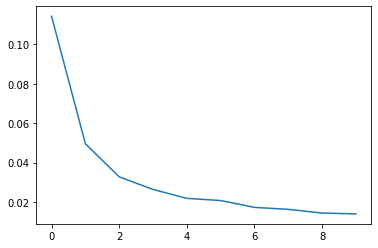

In [ ]:
tlr_cpu = [i.cpu().detach().numpy() for i in tlr]

plt.plot(tlr_cpu)

In [ ]:
result = []
prediction = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        output_sm = nn.Softmax(dim=1)(output)
        _, predicted = torch.max(output, 1)
        prediction.append(predicted)
        result.append(output_sm)
        
result = torch.stack(result).detach().cpu().numpy()
prediction = torch.stack(prediction).detach().cpu().numpy()

print(result.shape, prediction.shape)

(301, 64, 2) (301, 64)


In [ ]:
print(prediction.reshape(-1).shape)

(19264,)


In [ ]:
print(result.reshape(-1,2).shape)

(19264, 2)


In [ ]:
# save trained model
state_dict = {
    # 'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
if save_model:
  if pre_trained_on_node1_use_on_node2:
    torch.save(state_dict, save_path + 'pretrained_on_node1_reuse_node2.pt')
  elif pre_trained:
    torch.save(state_dict, save_path + 'pretrained_on_imagenet.pt')
  else:
    torch.save(state_dict, save_path + 'trained_on_node1.pt')


In [ ]:
import pandas as pd
res = pd.DataFrame(result.reshape(-1,2))
pred = pd.DataFrame(prediction.reshape(-1))

# res.to_csv(save_path + "results_pretrained_on_node1_reuse_node2.csv", header=True, index=True)
# pred.to_csv(save_path + "pred_pretrained_on_node1_reuse_node2.csv", header=True, index=True)

In [ ]:
print(res.shape, pred.shape)

y_test_new = y_train[:result.reshape(-1,2).shape[0]]

print(y_test_new.shape)

(19264, 2) (19264, 1)
(19264,)


In [ ]:
result_df = pd.DataFrame({'ground truth': y_test_new, 'NN output': prediction.reshape(-1), 'probs 0': res[0], 'probs 1': res[1]})
result_df

,ground truth,NN output,probs 0,probs 1
0,0.0,0,1.000000,2.030686e-08
1,0.0,0,1.000000,1.777344e-07
2,0.0,0,0.829535,1.704647e-01
3,0.0,0,0.999985,1.505606e-05
4,0.0,0,0.999994,6.212866e-06
...,...,...,...,...
19259,1.0,0,1.000000,1.049194e-09
19260,1.0,0,1.000000,4.311788e-09
19261,1.0,0,0.999997,2.935448e-06
19262,1.0,0,1.000000,3.529813e-09


In [ ]:
# work out the accuracy and other metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
actual = result_df['ground truth']
predicted = result_df['NN output']
# confusion matrix
matrix = confusion_matrix(actual, predicted, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual, predicted, labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix_2 = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix_2)

Confusion matrix : 
 [[7124 4255]
 [4340 3545]]
Outcome values : 
 7124 4255 4340 3545
Classification report : 
               precision    recall  f1-score   support

           1       0.45      0.45      0.45      7885
           0       0.62      0.63      0.62     11379

    accuracy                           0.55     19264
   macro avg       0.54      0.54      0.54     19264
weighted avg       0.55      0.55      0.55     19264



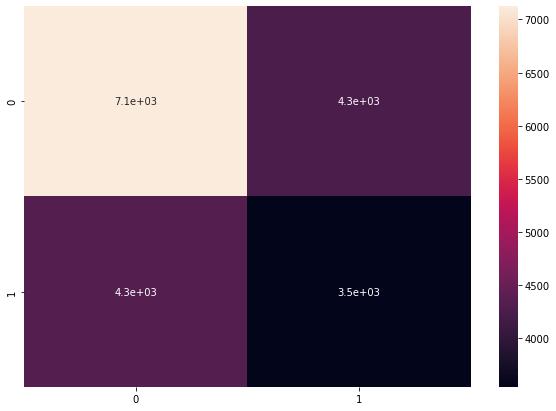

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
matrix = classification_report(actual,predicted,labels=[0,1], output_dict=True)
print('Classification report : \n',matrix)
accuracy_score(actual, predicted)

Classification report : 
 {'0': {'precision': 0.6214235868806699, 'recall': 0.6260655593637402, 'f1-score': 0.6237359366107779, 'support': 11379}, '1': {'precision': 0.4544871794871795, 'recall': 0.4495878249841471, 'f1-score': 0.4520242269684412, 'support': 7885}, 'accuracy': 0.5538309800664452, 'macro avg': {'precision': 0.5379553831839247, 'recall': 0.5378266921739436, 'f1-score': 0.5378800817896096, 'support': 19264}, 'weighted avg': {'precision': 0.5530943939665466, 'recall': 0.5538309800664452, 'f1-score': 0.5534521518033743, 'support': 19264}}


0.5538309800664452

In [ ]:
matrix_df = pd.DataFrame(matrix).transpose()
if save_results:
  if pre_trained_on_node1_use_on_node2:
    matrix_df.to_csv(save_path + "classification_report_pretrained_on_node1_reuse_node2.csv", header=False, index=False)
  elif pre_trained:
    matrix_df.to_csv(save_path + "classification_report_pretrained_on_imagenet.csv", header=False, index=False)
  else:
    matrix_df.to_csv(save_path + "classification_report_trained_on_node1.csv", header=False, index=False)

# pd.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/classification_report.txt",matrix)